## Imports

In [1]:
!pip install torcheval -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.9 MB/s eta 0:00:00


In [2]:
!pip install libauc -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.8 MB/s eta 0:00:00


In [3]:
!pip install ttach -q

In [4]:
!pip install --upgrade albumentations -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 1.9 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.2 MB/s eta 0:00:00


In [5]:
!git clone https://github.com/changzy00/pytorch-attention.git

Cloning into 'pytorch-attention'...
remote: Enumerating objects: 739, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 739 (delta 46), reused 36 (delta 11), pack-reused 645 (from 1)
Receiving objects: 100% (739/739), 3.51 MiB | 34.20 MiB/s, done.
Resolving deltas: 100% (339/339), done.


In [6]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1338, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 1338 (delta 127), reused 52 (delta 52), pack-reused 1164 (from 3)
Receiving objects: 100% (1338/1338), 137.57 MiB | 40.67 MiB/s, done.
Resolving deltas: 100% (755/755), done.


In [7]:
cd pytorch-attention

/kaggle/working/pytorch-attention


In [8]:
#!git clone https://github.com/haofanwang/Score-CAM.git

In [9]:
#cd Score-CAM/

In [10]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
import sys
import ttach
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 55)

In [11]:
sys.path.append('/kaggle/working/pytorch-grad-cam')

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc
from torch.utils.data import WeightedRandomSampler, Sampler

from attention_mechanisms.cbam import CBAM
from attention_mechanisms.simam import simam_module
from attention_mechanisms.lct import LCT

from libauc.losses import AUCMLoss, pAUCLoss, tpAUC_KL_Loss, pAUC_DRO_Loss, pAUC_CVaR_Loss
from libauc.metrics import pauc_roc_score
from libauc.sampler import DualSampler
from libauc.optimizers import SOTAs, PESG, SOPA, SOPAs
from libauc.sampler import DualSampler

import joblib
from tqdm import tqdm
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

sys.path.append('/content/Score-CAM')  # Add the repository to the path

from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

## Configuration

In [381]:
CONFIG = {
    "seed": 42,
    "epochs": 10,
    "img_size": 224,
    "test_img_size": 224,
    "model_name": "mobilenetv3_large_100", #'mobilenetv3_small_100', #"efficientnet_b5",   # "vit_base_patch16_224",  #"resnet50",
    "train_batch_size": 16,
    "valid_batch_size": 128,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-5,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "warm_up": False,
}

if CONFIG['model_name'] == "efficientnet_b1":
    CONFIG['img_size'] = 224
    CONFIG['test_img_size'] = 224
elif CONFIG['model_name'] == "efficientnet_b2":
    CONFIG['img_size'] = 256
    CONFIG['test_img_size'] = 256
elif CONFIG['model_name'] == "efficientnet_b3":
    CONFIG['img_size'] = 256
    CONFIG['test_img_size'] = 256
elif CONFIG['model_name'] == "efficientnet_b5":
    CONFIG['img_size'] = 256
    CONFIG['test_img_size'] = 256

print(CONFIG['img_size'])
print(CONFIG['test_img_size'])

In [14]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(CONFIG['seed'])

In [15]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [16]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

## Data loading

In [17]:
train_metadata = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')
train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,Torso Front Top Half,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,Torso Front Top Half,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [18]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [19]:
train_metadata['file_path'] = train_metadata['isic_id'].apply(get_train_file_path)
train_metadata = train_metadata[ train_metadata["file_path"].isin(train_images) ].reset_index(drop=True)
train_metadata

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,...,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.000000,3.982447,2.967674,-7.658253,8.360566,5.784302,...,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.000000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,/kaggle/input/isic-2024-challenge/train-image/...
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.000000,6.347830,1.781713,-6.500838,6.839008,4.987244,...,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.000000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,/kaggle/input/isic-2024-challenge/train-image/...
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.000000,5.447655,4.485044,-7.709336,9.092376,6.290359,...,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.000000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,/kaggle/input/isic-2024-challenge/train-image/...
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.514520,2.077572,0.326788,-4.665323,4.783413,6.400196,...,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.664690,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,/kaggle/input/isic-2024-challenge/train-image/...
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.000000,4.668053,0.754434,-8.579431,9.148495,6.531302,...,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.000000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,/kaggle/input/isic-2024-challenge/train-image/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,14.944666,27.663259,26.767135,35.705132,30.656525,50.784168,60.824438,36.333547,53.341997,22.893601,17.842449,2.579861,7.629668,0.896124,-17.008450,17.187750,13.498163,...,Torso Front,4.877998,9.936233e+01,3.101811,7.348126,20.

In [20]:
train_metadata_full = train_metadata.copy()

## Exploratory Analysis

In [21]:
train_metadata.describe(exclude=[np.number])

,isic_id,patient_id,sex,anatom_site_general,image_type,tbp_tile_type,tbp_lv_location,tbp_lv_location_simple,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,file_path
count,401059,401059,389542,395303,401059,401059,401059,401059,401059,401059,22058,401059,401059,1068,1065,551,1,53,401059
unique,401059,1042,2,5,1,2,21,8,7,3,22058,52,3,14,25,26,1,7,401059
top,ISIC_9999967,IP_1117889,male,posterior torso,TBP tile: close-up,3D: XP,Torso Back Top Third,Torso Back,Memorial Sloan Kettering Cancer Center,CC-BY,IL_9852274,Benign,Benign,Benign melanocytic proliferations,Nevus,"Nevus, Atypical, Dysplastic, or Clark","Blue nevus, Cellular",0/mm^2,/kaggle/input/isic-2024-challenge/train-image/...
freq,1,9184,265546,121902,401059,285903,71112,121902,129068,188812,1,399991,400552,443,443,228,1,22,1


In [22]:
pd.pivot_table(train_metadata, columns=['iddx_2', 'target'], values='isic_id', aggfunc='count')

iddx_2,Benign adnexal epithelial proliferations - Apocrine or Eccrine,Benign adnexal epithelial proliferations - Follicular,Benign epidermal proliferations,Benign melanocytic proliferations,Benign soft tissue proliferations - Fibro-histiocytic,Benign soft tissue proliferations - Vascular,Cysts,Flat melanotic pigmentations - not melanocytic nevus,Indeterminate epidermal proliferations,Indeterminate melanocytic proliferations,Inflammatory or infectious diseases,Malignant adnexal epithelial proliferations - Follicular,Malignant epidermal proliferations,Malignant melanocytic proliferations (Melanoma)
target,0,0,0,0,0,0,0,0,0,0,0,1,1,1
isic_id,1,2,83,443,15,3,2,5,39,75,7,163,73,157


In [23]:
max_width = 0
max_height = 0
height_list = []
width_list = []

sample = train_metadata.sample(n=500)['file_path'].tolist()

for img_path in sample:
    img = cv2.imread(img_path)
    if img is not None:
        height, width = img.shape[:2]
        height_list.append(height)
        width_list.append(width)
        max_width = max(max_width, width)
        max_height = max(max_height, height)

In [24]:
max_width

191

In [25]:
max_height

191

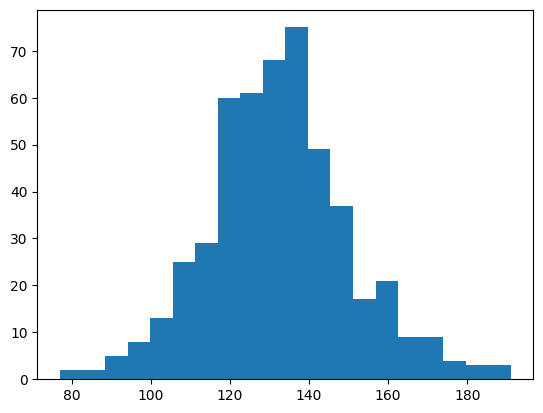

In [26]:
plt.hist(height_list, bins=20)
plt.show()

In [27]:
percentile_5th = np.percentile(height_list, 5)
percentile_95th = np.percentile(height_list, 95)

print(f"5th Percentile of Image Sizes: {percentile_5th}")
print(f"95th Percentile of Image Sizes: {percentile_95th}")

5th Percentile of Image Sizes: 103.0
95th Percentile of Image Sizes: 163.0


In [28]:
train_metadata.pivot_table(columns=['iddx_1', 'iddx_2'], values='target', aggfunc=['count'])

count  \
iddx_1                                                         Benign   
iddx_2 Benign adnexal epithelial proliferations - Apocrine or Eccrine   
target                                                  1               

                                                              \
iddx_1                                                         
iddx_2 Benign adnexal epithelial proliferations - Follicular   
target                                                  2      

                                                                          \
iddx_1                                                                     
iddx_2 Benign epidermal proliferations Benign melanocytic proliferations   
target                              83                               443   

                                                              \
iddx_1                                                         
iddx_2 Benign soft tissue proliferations - Fibro-histiocytic   
target                                                 15      

                                                           \
iddx_1                                                      
iddx_2 Benign soft tissue proliferations - Vascular Cysts   
target                                            3     2   

                                                             \
iddx_1                                                        
iddx_2 Flat melanotic pigmentations - not melanocytic nevus   
target                                                  5     

                                            \
iddx_1                                       
iddx_2 Inflammatory or infectious diseases   
target                                   7   

                                               \
iddx_1                          Indeterminate   
iddx_2 Indeterminate epidermal proliferations   
target                                     39   

                                                 \
iddx_1                                            
iddx_2 Indeterminate melanocytic proliferations   
target                                       75   

                                                                 \
iddx_1                                                Malignant   
iddx_2 Malignant adnexal epithelial proliferations - Follicular   
target                                                163         

                                           \
iddx_1                                      
iddx_2 Malignant epidermal proliferations   
target                                 73   

                                                        
iddx_1                                                  
iddx_2 Malignant melanocytic proliferations (Melanoma)  
target                                             157

In [29]:
train_metadata.describe(include=[np.number])

,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
count,401059.000000,398261.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,63.000000,4.010590e+05
mean,0.000980,58.012986,3.930827,19.974007,14.919247,28.281706,26.913015,34.786341,30.921279,54.653689,60.996869,42.289976,51.199529,8.539975,19.084517,1.070408,5.054760,1.368691,-8.909552,9.455766,7.538922,0.741238,2.539773,38.520265,3.451523,3.091590,11.878891,1.016459,2.715190,2.238605,0.306823,86.332073,-3.091862,1039.598221,55.823389,0.670952,9.716220e+01
std,0.031288,13.596165,1.743068,3.999489,3.529384,5.278676,4.482994,5.708469,4.829345,5.520849,5.631909,10.864572,12.100527,9.679312,5.357863,0.762918,2.642928,2.215871,3.463362,3.466703,2.404951,0.143857,1.173169,41.480936,1.724557,2.044813,5.919302,0.734631,1.738165,0.623884,0.125038,52.559511,197.257995,409.819653,87.968245,0.792798,8.995782e+00
min,0.000000,5.000000,1.000000,-2.487115,-9.080269,-0.730989,9.237066,3.054228,11.846520,-1.574164,28.436490,4.223007,17.702260,0.431601,10.761634,0.000000,-13.819850,-18.088106,-38.756140,2.952675,3.001138,0.027667,0.273973,0.000000,0.589426,0.000000,2.579237,0.000000,0.268160,0.636247,0.052034,0.000000,-624.870728,-1052.134000,-291.890442,0.200000,1.261082e-16
25%,0.000000,50.000000,2.840000,17.330821,12.469740,24.704372,23.848125,31.003148,27.658285,51.566273,57.297630,34.303345,42.274506,4.109589,15.426205,0.574909,3.413108,0.111030,-10.675470,6.952377,5.748160,0.656627,1.812707,0.109819,2.143836,1.728774,8.338364,0.563891,1.456570,1.834745,0.211429,40.000000,-147.022125,746.519673,-8.962647,0.300000,9.966882e+01
50%,0.000000,60.000000,3.370000,19.801910,14.713930,28.171570,26.701704,34.822580,30.804893,55.035632,61.109173,42.343770,51.425557,5.685870,17.423950,0.931402,4.643926,1.593945,-8.132223,8.699932,6.946320,0.768215,2.265201,14.408514,2.996933,2.764664,10.015440,0.902281,2.186693,2.149758,0.282297,90.000000,-5.747253,1172.803000,67.957947,0.400000,9.999459e+01
75%,0.000000,70.000000,4.380000,22.304628,17.137175,31.637429,29.679913,38.430298,33.963868,58.298184,64.905025,50.405051,60.495607,9.119910,21.011340,1.412154,6.274246,2.850638,-6.397103,11.243486,8.748403,0.853175,2.905918,87.791395,4.358399,4.120246,13.209100,1.334523,3.474565,2.531443,0.382022,130.000000,140.474835,1342.131540,126.611567,0.600000,9.999996e+01
max,1.000000,85.000000,28.400000,48.189610,37.021680,54.306900,48.372700,58.765170,54.305290,105.875784,130.983300,87.548888,98.588250,334.152700,87.205340,9.952932,32.137590,12.643930,-1.590631,39.197720,30.487456,0.974960,18.387900,100.000000,10.000000,10.000000,102.493900,11.491140,17.563650,25.534791,0.977055,175.000000,614.471700,1887.766846,319.407000,5.000000,1.000000e+02


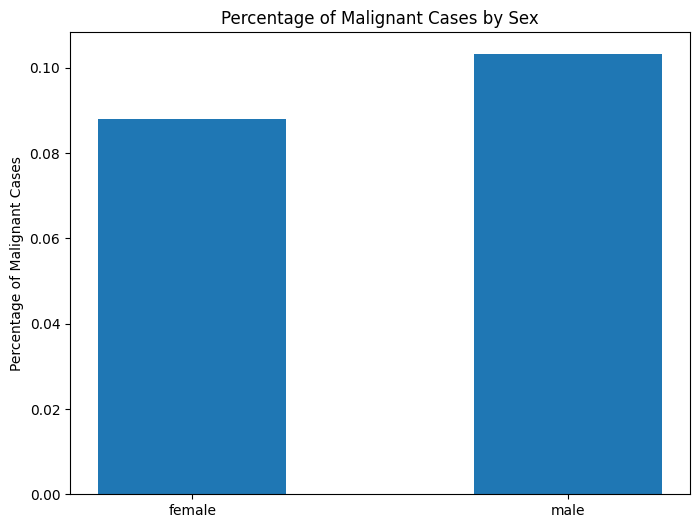

In [30]:
sex_target_counts = train_metadata_full.groupby(['sex', 'target'])['isic_id'].count().unstack()

malignant_percentages = sex_target_counts[1].div(sex_target_counts.sum(axis=1)) * 100

x_positions = np.arange(len(malignant_percentages.index))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_positions, malignant_percentages, width=0.5, label='Malignant')  # Only malignant bar

ax.set_xticks(x_positions)
ax.set_xticklabels(malignant_percentages.index)
ax.set_ylabel("Percentage of Malignant Cases")
ax.set_title("Percentage of Malignant Cases by Sex")

plt.show()

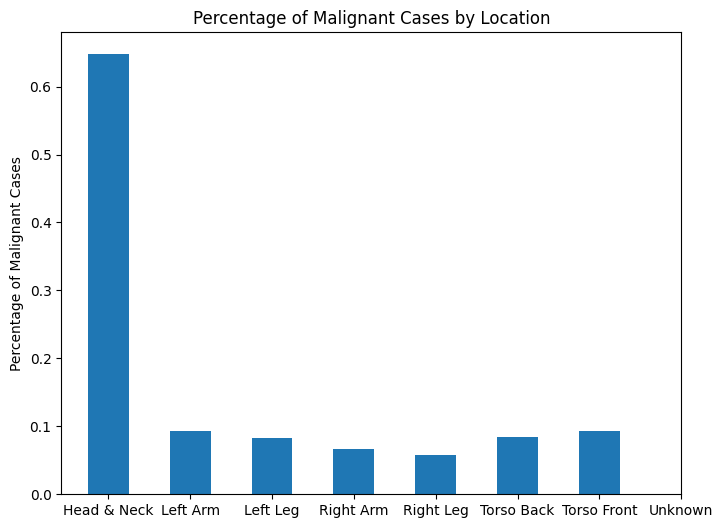

In [31]:
sex_target_counts = train_metadata_full.groupby(['tbp_lv_location_simple', 'target'])['isic_id'].count().unstack()

malignant_percentages = sex_target_counts[1].div(sex_target_counts.sum(axis=1)) * 100

x_positions = np.arange(len(malignant_percentages.index))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_positions, malignant_percentages, width=0.5, label='Malignant')  # Only malignant bar

ax.set_xticks(x_positions)
ax.set_xticklabels(malignant_percentages.index)
ax.set_ylabel("Percentage of Malignant Cases")
ax.set_title("Percentage of Malignant Cases by Location")

plt.show()

In [32]:
def layout_images(paths, x, y):
    fig, axes = plt.subplots(x, y, figsize=(12, 6))

    for i, image_path in enumerate(paths):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        row = i // 4
        col = i % 4
        axes[row, col].imshow(image)
        axes[row, col].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

In [ ]:
random_image_paths = random.sample(
    train_metadata.query('tbp_lv_dnn_lesion_confidence < 5 and iddx_1 == "Benign"')['file_path'].tolist(), 
    12
)
print(random_image_paths)

check_benign = [
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5738700.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0323417.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5691802.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_9811770.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_2085558.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_6960640.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_4239987.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_4214147.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_8128501.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_8109237.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0228301.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5497738.jpg'
]

layout_images(random_image_paths, 3, 4)

['/kaggle/input/isic-2024-challenge/train-image/image/ISIC_7585032.jpg', '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_8626891.jpg', '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_1630203.jpg', '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_9343794.jpg', '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_6192314.jpg', '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5398284.jpg', '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0276162.jpg', '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_1097579.jpg', '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_3400253.jpg', '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_6613721.jpg', '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_3041803.jpg', '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_1488609.jpg']


In [ ]:
random_image_paths = random.sample(
    train_metadata.query('iddx_1 == "Benign"')['file_path'].tolist(), 
    12
)
print(random_image_paths)

layout_images(random_image_paths, 3, 4)

In [ ]:
random_image_onepatient_paths = random.sample(
    train_metadata.query('patient_id == "IP_1235828"')['file_path'].tolist(), 12
)

layout_images(random_image_onepatient_paths, 3, 4)

In [ ]:
random_image_malignant_paths = random.sample(
    train_metadata.query('iddx_1 == "Malignant"')['file_path'].tolist(), 12
)

layout_images(random_image_malignant_paths, 3, 4)

In [ ]:
random_image_malignant_paths

largest_size = 0
largest_image_path = ""

for image_path in train_images[:10000]:
    image = cv2.imread(image_path)
    size = image.shape[0] * image.shape[1]  # Calculate image size as width * height

    if size > largest_size:
        largest_size = size
        largest_image_path = image_path

print(f"Largest image size: {largest_size} pixels")
print(f"Largest image path: {largest_image_path}")
print(f"Largest image width: {cv2.imread(largest_image_path).shape[1]}")
print(f"Largest image height: {cv2.imread(largest_image_path).shape[0]}")

## Preparing Tabular Data

In [ ]:
train_metadata_applied = train_metadata.copy()

In [ ]:
train_metadata_applied = train_metadata_applied.loc[
    :, 
    ['patient_id', 'target', 'sex', 'age_approx', 'tbp_lv_location_simple', 'clin_size_long_diam_mm', 'file_path']
]

In [ ]:
train_metadata_applied.isna().sum()

In [ ]:
#sex_mapping = {'male': 0, 'female': 1}  

#train_metadata_applied['sex_bin'] = train_metadata_applied['sex'].map(sex_mapping)

In [42]:
dummy_variables_sex = pd.get_dummies(train_metadata_applied['sex'], prefix='sex', dummy_na=True)

train_metadata_applied = pd.concat([train_metadata_applied, dummy_variables_sex], axis=1)

In [43]:
age_mean = train_metadata_applied['age_approx'].mean()
age_std = train_metadata_applied['age_approx'].std()

train_metadata_applied['age_standardized'] = (train_metadata_applied['age_approx'] - age_mean) / age_std

In [44]:
size_mean = train_metadata_applied['clin_size_long_diam_mm'].mean()
size_std = train_metadata_applied['clin_size_long_diam_mm'].std()

train_metadata_applied['size_standardized'] = (train_metadata_applied['clin_size_long_diam_mm'] - size_mean) / size_std

In [45]:
dummy_variables = pd.get_dummies(train_metadata_applied['tbp_lv_location_simple'], prefix='location')

train_metadata_applied = pd.concat([train_metadata_applied, dummy_variables], axis=1)

In [46]:
train_metadata_applied = train_metadata_applied.drop(
    ['sex', 'age_approx', 'tbp_lv_location_simple', 'clin_size_long_diam_mm'], 
    axis=1
)

In [47]:
train_metadata_applied.head()

,patient_id,target,file_path,sex_female,sex_male,sex_nan,age_standardized,size_standardized,location_Head & Neck,location_Left Arm,location_Left Leg,location_Right Arm,location_Right Leg,location_Torso Back,location_Torso Front,location_Unknown
0,IP_1235828,0,/kaggle/input/isic-2024-challenge/train-image/...,False,True,False,0.146145,-0.511068,False,False,False,False,True,False,False,False
1,IP_8170065,0,/kaggle/input/isic-2024-challenge/train-image/...,False,True,False,0.146145,-1.624048,True,False,False,False,False,False,False,False
2,IP_6724798,0,/kaggle/input/isic-2024-challenge/train-image/...,False,True,False,0.146145,-0.304536,False,False,False,False,False,True,False,False
3,IP_4111386,0,/kaggle/input/isic-2024-challenge/train-image/...,False,True,False,0.513896,-0.407802,False,False,False,False,False,False,True,False
4,IP_8313778,0,/kaggle/input/isic-2024-challenge/train-image/...,False,True,False,-0.221606,-0.688916,False,False,False,False,False,False,True,False


In [48]:
#train_metadata_applied['sex_bin'] = train_metadata_applied['sex_bin'].fillna(value = 1.0)

In [49]:
train_metadata_applied['age_standardized'] = train_metadata_applied['age_standardized'].fillna(value=train_metadata_applied['age_standardized'].mean())

In [50]:
train_metadata_applied.shape

(401059, 16)

## Undersampling

In [51]:
def undersample(data, ratio):
    print("df.shape, # of positive cases, # of patients")
    print("original>", data.shape, train_metadata_applied.target.sum(), data["patient_id"].unique().shape)

    df_positive = data[data["target"] == 1].reset_index(drop=True)
    df_negative = data[data["target"] == 0].reset_index(drop=True)

    data_sampled = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*ratio, :]])
    print("filtered>", data_sampled.shape, data_sampled.target.sum(), data_sampled["patient_id"].unique().shape)

    return data_sampled

In [52]:
train_metadata_applied = undersample(train_metadata_applied, ratio=100)

df.shape, # of positive cases, # of patients
original> (401059, 16) 393 (1042,)
filtered> (39693, 16) 393 (1028,)


## Folds

In [53]:
CONFIG['T_max'] = train_metadata_applied.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

99232

In [54]:
train_metadata_applied = train_metadata_applied.reset_index(drop=True)
train_metadata_applied["kfold"] = -1

sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(sgkf.split(train_metadata_applied, train_metadata_applied.target, train_metadata_applied.patient_id)):
      train_metadata_applied.loc[val_ , "kfold"] = int(fold)

In [55]:
def assign_folds(data, num_positive_fold0=70, num_negative_fold0=4410, fold_train=1):
    """Assigns folds to the data.

    Args:
        data: The input DataFrame.
        num_positive_fold0: Number of positive samples for fold 0.
        num_negative_fold0: Number of negative samples for fold 0.
        fold_train: The fold number to use for training.

    Returns:
        The DataFrame with a new 'kfold' column indicating the fold assignments.
    """
    
    data = data.copy()
    data["kfold"] = fold_train

    # Do not reset index — we keep the original row positions
    positive_idx = data[data["target"] == 1].index[:num_positive_fold0]
    negative_idx = data[data["target"] == 0].index[:num_negative_fold0]

    fold0_indices = np.concatenate([positive_idx, negative_idx])
    data.loc[fold0_indices, "kfold"] = 0

    return data

In [56]:
train_metadata_applied = assign_folds(train_metadata_applied)

In [57]:
train_metadata_applied['kfold'].value_counts()

kfold
1    35213
0     4480
Name: count, dtype: int64

In [58]:
train_metadata_applied.pivot_table(columns='kfold', values = 'target', aggfunc='sum')

kfold,0,1
target,70,323


## PyTorch Dataset Class

In [59]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None, train_val_ratio=2, positive_prob=0.5):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        self.train_val_ratio = train_val_ratio
        self.positive_prob = positive_prob

    def __len__(self):
        return len(self.df_positive) * self.train_val_ratio

    def __getitem__(self, index):
        if random.random() >= self.positive_prob:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative

        index = index % df.shape[0]

        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target,
            'index': index
        }

class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target,
            'index': index
        }

## Augmentations

In [60]:
data_transforms_baseline = {
    "train": A.Compose(
        [
        A.LongestMaxSize(CONFIG['img_size']),
        A.PadIfNeeded(min_height=CONFIG['img_size'], min_width=CONFIG['img_size'],
                  border_mode=cv2.BORDER_CONSTANT, fill=0, p=1.0),
        A.Normalize(
                max_pixel_value=255.0,
                normalization='standard',
                p=1.0
            ),
        ToTensorV2()
        ],
        strict=True,
        p=1.),

    "valid": A.Compose(
        [
        A.LongestMaxSize(CONFIG['img_size']),
        A.PadIfNeeded(min_height=CONFIG['img_size'], min_width=CONFIG['img_size'],
                  border_mode=cv2.BORDER_CONSTANT, fill=0, p=1.0),
        A.Normalize(
                max_pixel_value=255.0,
                normalization='standard',
                p=1.0
        ),
        ToTensorV2()
        ],
        strict=True,
        p=1.0,
        seed=42
    )
}

### Calculating means and stds

In [61]:
dataset_for_stats = ISICDataset(train_metadata_applied.sample(n=1000), transforms=data_transforms_baseline['train'])

In [62]:
mean_sum = torch.zeros(3)
std_sum = torch.zeros(3)
mean_min = 255

num_images = len(dataset_for_stats)

#for data in tqdm(dataset_for_stats):
    #img = data['image'].type(torch.float32)
    # print(img.shape)
    #mean = img.mean(dim=[1, 2])
    #mean_sum += mean  # Calculate mean per channel across all images
    #if mean.tolist() < mean_min:
        #mean_min = mean.tolist()
    #std_sum += img.std(dim=[1, 2])  # Calculate std per channel across all images

In [63]:
mean = (mean_sum / num_images) / 255
std = (std_sum / num_images) / 255

In [64]:
mean.tolist()

[0.0, 0.0, 0.0]

In [65]:
mean_min

255

In [66]:
std.tolist()

[0.0, 0.0, 0.0]

### Target transforms

In [67]:
def enhance_dark_images(image, threshold=100, gamma=0.5, **kwargs):
    """
    Brightens dark images using gamma correction if their brightness is below a threshold.

    Args:
        image: Input RGB image (numpy array, uint8)
        threshold: Brightness threshold (default: 100, range 0-255)
        gamma: Gamma value < 1 for brightening (default: 0.5)

    Returns:
        Processed image (numpy array, uint8)
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mean_brightness = np.mean(gray)
    #print(mean_brightness)

    if mean_brightness < threshold:
        image_float = image.astype(float)
        image_float = 255 * (image_float / 255.0) ** gamma
        image = np.clip(image_float, 0, 255).astype(np.uint8)

    return image

In [68]:
data_transforms = {
    "train": A.Compose(
        [
        A.LongestMaxSize(CONFIG['img_size']),
        A.PadIfNeeded(min_height=CONFIG['img_size'], min_width=CONFIG['img_size'],
                  border_mode=cv2.BORDER_CONSTANT, fill=0, p=1.0),
        A.CLAHE(clip_limit=(2.40, 2.60), tile_grid_size=(7, 7), p=1.0),
        A.SquareSymmetry(p=0.7),
        A.Affine(
            scale=(0.8, 1.2),      # Zoom in/out by 80-120%
            rotate=(-15, 15),      # Rotate by -15 to +15 degrees
            # translate_percent=(0, 0.1), # Optional: translate by 0-10%
            # shear=(-5, 5),          # Optional: shear by -10 to +10 degrees
            p=0.6
        ),
        A.ElasticTransform(
            alpha=1.2,
            sigma=30,
            p=0.4
        ),
        A.OneOf([
            A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(0.07, 0.11),
                            hole_width_range=(0.07, 0.11), fill=0, p=1.0),
            A.GridDropout(ratio=0.2, p=1.0)
        ], p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.12, contrast_limit=0.05, p=0.6),
            A.RandomGamma(gamma_limit=(80, 120), p=0.6),
        ], p=0.7),
        #A.OneOf([
            #A.GaussianBlur(blur_limit=(2, 4), p=0.4),
            #A.MedianBlur(blur_limit=3, p=0.4),
            #A.MotionBlur(blur_limit=(1, 3), p=0.4),
        #], p=0.25),
        A.Normalize(
                mean=[0.6976747512817383, 0.5208521485328674, 0.41849368810653687],
                std=[0.04824119806289673, 0.054282333701848984, 0.0521312952041626],
                max_pixel_value=255.0,
                normalization="image",
                p=1.0
            ),
        ToTensorV2()
        ],
        strict=True,
        p=1.),

    "valid": A.Compose(
        [
        A.LongestMaxSize(CONFIG['img_size']),
        A.PadIfNeeded(min_height=CONFIG['img_size'], min_width=CONFIG['img_size'],
                  border_mode=cv2.BORDER_CONSTANT, fill=0, p=1.0),
        A.CLAHE(
           clip_limit=(2.50, 2.501),
           tile_grid_size=(7, 7),
           p = 1.0
        ),
        A.Normalize(
                mean=[0.6976747512817383, 0.5208521485328674, 0.41849368810653687],
                std=[0.04824119806289673, 0.054282333701848984, 0.0521312952041626],
                max_pixel_value=255.0,
                normalization='image',
                p=1.0
        ),
        ToTensorV2()
        ],
        strict=True,
        p=1.0,
        seed=42
    )
}

In [69]:
data_transforms_exp = {
    "train": A.Compose(
        [
        A.LongestMaxSize(CONFIG['img_size'], interpolation=cv2.INTER_CUBIC),
        A.PadIfNeeded(min_height=CONFIG['img_size'], min_width=CONFIG['img_size'],
                  border_mode=cv2.BORDER_CONSTANT, fill=0, p=1.0),
        A.CLAHE(clip_limit=(1.5, 1.5), tile_grid_size=(12, 12), p=1.0),
        A.SquareSymmetry(p=0.7),
        A.Affine(
            scale=(0.8, 1.2),            # Zoom in/out by 80-120%
            rotate=(-15, 15),            # Rotate by -15 to +15 degrees
            # translate_percent=(0, 0.1), # Optional: translate by 0-10%
            shear=(-5, 5),              # Optional: shear by -10 to +10 degrees
            p=0.7
        ),
        A.OneOf([
            A.CoarseDropout(num_holes_range=(1, 9), hole_height_range=(0.07, 0.12),
                            hole_width_range=(0.07, 0.12), fill=0, p=1.0),
            A.GridDropout(ratio=0.22, p=1.0)
        ], p=0.5),
        #A.OneOf([
            #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.7),
            #A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=15, p=0.7),
        #], p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.075, p=0.6),
            A.RandomGamma(gamma_limit=(80, 120), p=0.6),
        ], p=0.7),
        #A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.ElasticTransform(
            alpha=30,
            sigma=25,
            p=0.4
        ),
        A.Normalize(
                max_pixel_value=255.0,
                normalization="image",
                p=1.0
            ),
        ToTensorV2()
        ],
        strict=True,
        p=1.0,
        seed=42),

    "valid": A.Compose(
        [
        A.LongestMaxSize(CONFIG['img_size'], interpolation=cv2.INTER_CUBIC),
        A.PadIfNeeded(min_height=CONFIG['img_size'], min_width=CONFIG['img_size'],
                  border_mode=cv2.BORDER_CONSTANT, fill=0, p=1.0),
        A.CLAHE(clip_limit=(1.5, 1.5), tile_grid_size=(12, 12), p=1.0),
        A.Normalize(
                max_pixel_value=255.0,
                normalization="image",
                p=1.0
            ),
        ToTensorV2()
        ],
        strict=True,
        p=1.0,
        seed=42
    )
}

### Visualizing augmentations

In [70]:
def visualize_augmentations(image_paths, transform, rows=4, cols=4, figsize=(15, 10)):
    """
    Shows original -> augmented pairs for the first N images.
    Now properly handles both Albumentations and torchvision transforms.
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel()

    # We'll show pairs, so only half as many images
    num_images = min(rows * cols // 2, len(image_paths))

    for i in range(num_images):
        # Read original image
        img = cv2.imread(image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Original image (left)
        axes[i*2].imshow(img)
        axes[i*2].set_title("Original")
        axes[i*2].axis('off')

        # Augmented image (right)
        if isinstance(transform, A.Compose):
            # Albumentations
            augmented = transform(image=img)['image']
            #print(augmented.shape)
            display_img = augmented.permute(1, 2, 0)

        axes[i*2+1].imshow(display_img)
        axes[i*2+1].set_title("Augmented")
        axes[i*2+1].axis('off')

    # Hide unused axes if we have odd number of columns
    for j in range(num_images*2, rows*cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
image_onepatient_paths = [
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0811515.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0541500.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5366444.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_7316504.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0322693.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0287703.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5400739.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_1792562.jpg',
]

visualize_augmentations(image_onepatient_paths, transform=data_transforms['train'], rows=4, cols=4)

In [ ]:
visualize_augmentations(image_onepatient_paths, transform=data_transforms_baseline['train'], rows=4, cols=4)

In [73]:
visualize_augmentations(image_onepatient_paths, transform=data_transforms_exp['train'], rows=4, cols=4)

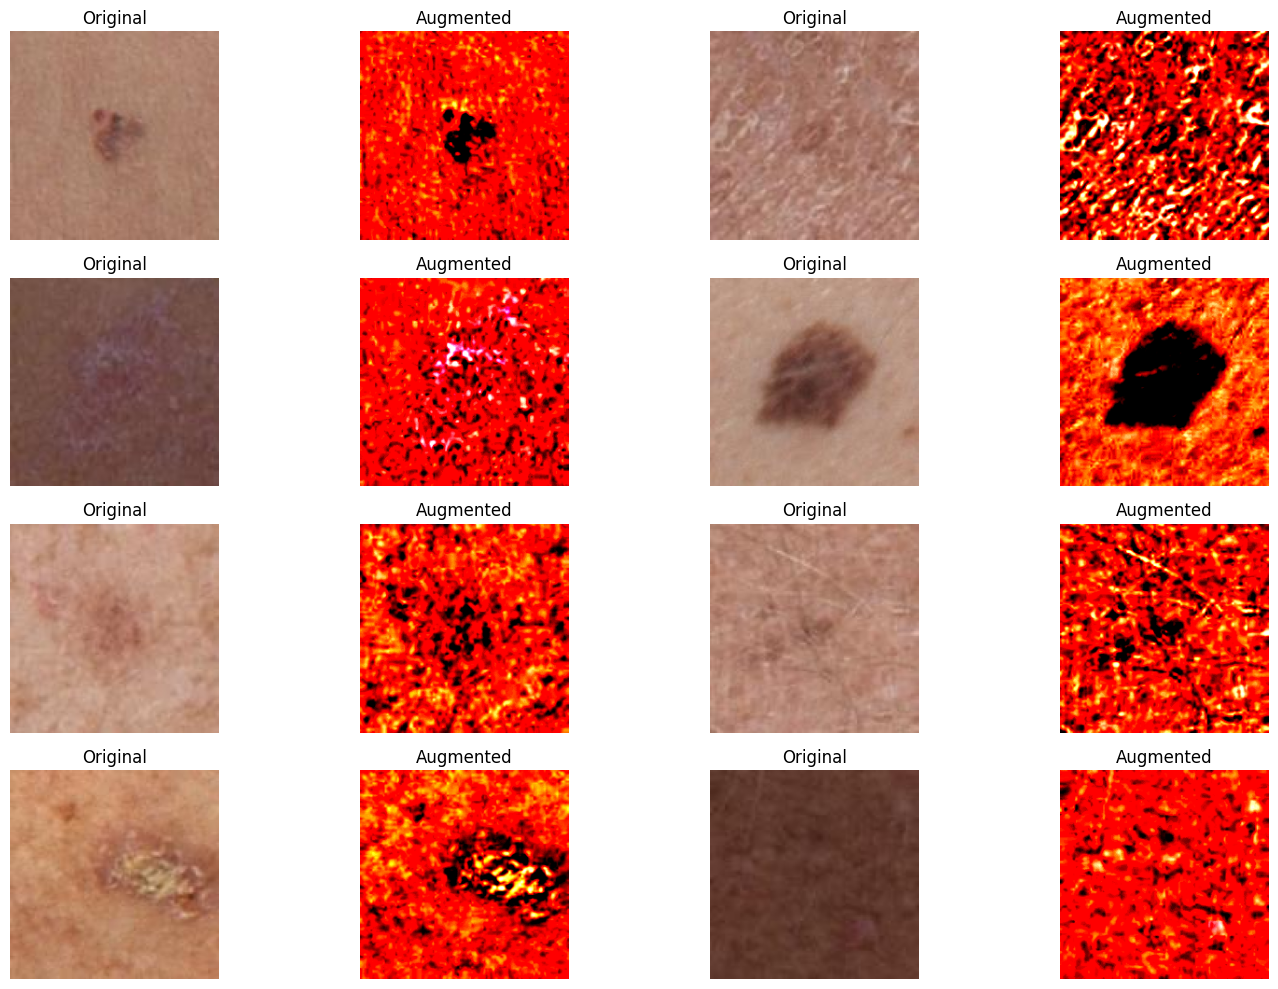

In [74]:
visualize_augmentations(image_onepatient_paths, transform=data_transforms_exp['valid'], rows=4, cols=4)

## GeM Pooling class

In [75]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

## Model

In [382]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None, rethink_in_features=False):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
                
        if hasattr(self.model, 'fc'):
            in_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
            print('fc')
        elif hasattr(self.model, 'classifier'):
            in_features = self.model.num_features
            self.model.classifier = nn.Identity()
            print('classifier')
        elif hasattr(self.model, 'head'):
            in_features = self.model.head.in_features
            self.model.head = nn.Identity()
            print('head')
        else:
            raise ValueError("Unknown classifier head in model")

        self.model.global_pool = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)

        self.linear = nn.Linear(in_features, num_classes)

    def forward(self, images):
        features = self.model.forward_features(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.linear(pooled_features)
        
        return output

In [329]:
class ViTWithTabular(nn.Module):
    def __init__(self, tabular_dim=12, model_name='vit_base_patch16_224', pretrained=True):
        super().__init__()
        self.vit = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.vit_head_dim = self.vit.num_features

        self.tabular_net = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.classifier = nn.Linear(self.vit_head_dim + 32, 1)

    def forward(self, x_img, x_tab):
        x_vit = self.vit(x_img)  # [B, vit_dim]
        x_tab = self.tabular_net(x_tab)
        x = torch.cat([x_vit, x_tab], dim=1)
        return self.classifier(x)

In [330]:
class ViT_Model(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', pretrained=True):
        super().__init__()
        self.vit = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.vit_head_dim = self.vit.num_features

        self.classifier = nn.Linear(self.vit_head_dim , 1)

    def forward(self, x_img):
        x_vit = self.vit(x_img)  # [B, vit_dim]
        return self.classifier(x_vit)

In [331]:
class Model_SimAM(nn.Module):
    """
    EfficientNet backbone with a single SimAM attention block applied
    right after the final convolution (conv_head) and before global pooling.
    """
    def __init__(self, model_name: str, pretrained: bool = True, num_classes: int = 1, e_lambda: float = 1e-4):
        super().__init__()
        # Load EfficientNet without its classifier
        backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)

        # Copy feature extractor layers
        self.conv_stem   = backbone.conv_stem
        self.bn1         = backbone.bn1
        self.blocks      = backbone.blocks
        self.conv_head   = backbone.conv_head
        self.bn2         = backbone.bn2
        self.global_pool = backbone.global_pool  # typically SelectAdaptivePool2d(flatten=True)

        # SimAM requires number of channels
        # number of output channels from conv_head
        channels = (backbone.conv_head.out_channels)
        self.simam = simam_module(channels=channels, e_lambda=e_lambda)

        # Final linear classifier
        self.classifier = nn.Linear(channels, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Stem + blocks
        x = self.conv_stem(x)
        x = self.bn1(x)
        x = self.blocks(x)

        # Head conv + BN
        x = self.conv_head(x)
        x = self.bn2(x)

        # Apply SimAM attention on spatial map
        x = self.simam(x)

        # Global pooling -> (batch, channels)
        x = self.global_pool(x)
        if x.dim() > 2:
            x = x.flatten(1)

        # Classifier
        logits = self.classifier(x)
        return logits


In [332]:
class Model_CBAM(nn.Module):
    """
    Example: Integrate CBAM into a timm backbone before global pooling.
    """
    def __init__(self, model_name='efficientnet_b3', pretrained=True, num_classes=1,reduction=16, kernel_size=7):
        super(Model_CBAM, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained,
                                          num_classes=0)
        self.num_features = self.backbone.num_features
        self.cbam = CBAM(channel=self.num_features,
                         reduction=reduction,
                         kernel_size=kernel_size)
        self.backbone.global_pool = nn.Identity()
        self.backbone.classifier = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(self.num_features, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        attn = self.cbam(features)
        pooled = self.pooling(attn)
        flattened = pooled.view(pooled.size(0), -1)
        logits = self.linear(flattened)
        return logits

In [333]:
class Model_LCT(nn.Module):
    """
    Example: Integrate CBAM into a timm backbone before global pooling.
    """
    def __init__(self, model_name='efficientnet_b3', pretrained=True, num_classes=1,
                 reduction=16, kernel_size=7):
        super(Model_LCT, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.num_features = self.backbone.num_features
        self.lct = LCT(self.num_features, groups=8)
        self.backbone.global_pool = nn.Identity()
        self.backbone.classifier = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(self.num_features, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        attn = self.lct(features)
        pooled = self.pooling(attn)
        flattened = pooled.view(pooled.size(0), -1)
        logits = self.linear(flattened)
        return logits

In [334]:
class Model_CBAM_Tabular(nn.Module):
    def __init__(self, model_name, pretrained=True, num_classes=1, tabular_dim=12):
        super(Model_CBAM_Tabular, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        self.channels = self.backbone.num_features
        self.cbam = CBAM(self.channels)

        # Tabular MLP
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Combine CNN + tabular features
        self.classifier = nn.Linear(self.channels + 32, num_classes)

    def forward(self, x_img, x_tab):
        features = self.backbone(x_img)  # [B, C]
        b, c = features.shape
        feat_map = features.view(b, c, 1, 1)
        attn_map = self.cbam(feat_map)
        attn_vec = attn_map.view(b, c)

        tab_vec = self.tabular_net(x_tab)  # [B, 32]

        x = torch.cat([attn_vec, tab_vec], dim=1)
        logits = self.classifier(x)
        return logits

In [335]:
class Model_SimAM_Tabular(nn.Module):
    """
    EfficientNet backbone with SimAM applied on the final spatial feature map.
    """
    def __init__(self, model_name, pretrained=True, num_classes=1, e_lambda=1e-4, tabular_dim=12):
        super(Model_SimAM_Tabular, self).__init__()
        full = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
        
        self.conv_stem   = full.conv_stem
        self.bn1         = full.bn1
        self.blocks      = full.blocks
        self.conv_head   = full.conv_head
        self.bn2         = full.bn2
        self.global_pool = full.global_pool
        self.simam       = simam_module(channels=full.num_features, e_lambda=e_lambda)

        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        self.classifier  = nn.Linear(full.num_features + 16, num_classes)

    def forward(self, x, x_tab):
        x = self.conv_stem(x)
        x = self.bn1(x)
        for block in self.blocks:
            x = block(x)
        x = self.conv_head(x)
        x = self.bn2(x)
        x = self.simam(x)
        x = self.global_pool(x)
        tab_vec = self.tabular_net(x_tab)
        
        x_full = torch.cat([x, tab_vec], dim=1)
        
        logits = self.classifier(x_full)
        return logits

In [336]:
class Model_Tabular(nn.Module):
    def __init__(self, model_name, pretrained=True, num_classes=1, e_lambda=1e-4, tabular_dim=12):
        super(Model_Tabular, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        
        self.num_features = self.backbone.num_features
        
        self.backbone.global_pool = nn.Identity()
        self.backbone.classifier = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        
        self.linear = nn.Linear(self.num_features, num_classes)
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU()
        )

    def forward(self, x, x_tab):
        x = self.backbone(x)
        x = self.pooling(x).flatten(1)
        tab_vec = self.tabular_net(x_tab)
        
        x_full = torch.cat([x, tab_vec], dim=1)
        logits = self.linear(x_full)
        return logits

In [383]:
model = ISICModel(CONFIG['model_name'], pretrained=True)
#model = ViT_Model(CONFIG['model_name'], pretrained=True)
#model = Model_CBAM_Tabular(CONFIG['model_name'], pretrained=True)
#model = ViTWithTabular(CONFIG['model_name'], pretrained=True)
#model = Model_CBAM(CONFIG['model_name'], pretrained=True)
#model = Model_SimAM(CONFIG['model_name'], pretrained=True)
#model = Model_LCT(CONFIG['model_name'], pretrained=True)
#model = Model_SimAM_Tabular(CONFIG['model_name'], pretrained=True)
model.to(CONFIG['device']);

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable_params:,}")
print(f"Total params:     {total_params:,}")

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

classifier
Trainable params: 4,202,993
Total params:     4,202,993


## Loss function

In [384]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        """
        Args:
            alpha (float or Tensor): balancing factor for classes (can be scalar or per-class tensor)
            gamma (float): focusing parameter (usually 2.0)
            reduction (str): 'none' | 'mean' | 'sum'
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: raw logits (before sigmoid/softmax), shape (B, C) or (B,)
            targets: ground truth class indices or binary labels, shape (B,) or (B, C)
        """
        if inputs.dim() > 1 and inputs.size(1) > 1:
            # Multiclass case
            logpt = F.log_softmax(inputs, dim=1)
            pt = torch.exp(logpt)
            logpt = logpt.gather(1, targets.unsqueeze(1)).squeeze(1)
            pt = pt.gather(1, targets.unsqueeze(1)).squeeze(1)
        else:
            # Binary case
            logpt = F.logsigmoid(inputs)
            pt = torch.exp(logpt)
            logpt = logpt * targets + F.logsigmoid(-inputs) * (1 - targets)
            pt = pt * targets + torch.exp(F.logsigmoid(-inputs)) * (1 - targets)

        loss = -self.alpha * (1 - pt) ** self.gamma * logpt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [385]:
def criterion(outputs, targets, index, df_valid):
    #loss_fn = pAUC_CVaR_Loss(
        #data_len=35213,
        #pos_len=323,
        #margin=1.0,
        #beta=0.5,
        #eta=0.1,
        #surr_loss='squared_hinge',
        #device=CONFIG['device']
    #)
    loss_fn = tpAUC_KL_Loss(
        data_len=35213,     # total training samples
        tau=0.25,  # TPR lower bound α
        Lambda=1.0, # KL‑divergence weight
        margin=0.75, # surrogate margin
        gammas=(0.8,0.5), # moving‑avg factors
        surr_loss= 'squared_hinge',
        device=CONFIG['device']
    )
    loss = loss_fn(
        outputs,
        targets,
        index,
        # auto=False
    )
    return loss

In [386]:
def criterion_warmup(outputs, targets, index, df_valid, pos_weight=None):
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    #loss_fn = FocalLoss(alpha=1.0, gamma=2.0)
    loss = loss_fn(outputs,targets)
    return loss

## Metric

In [387]:
import pandas.api.types
from sklearn.metrics import roc_curve, auc, roc_auc_score

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC

    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC)
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.

    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    if len(np.unique(solution.values)) < 2:
             return 0.5  # Or skip the calculation for this batch

    v_gt = abs(np.asarray(solution.values)-1)

    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    #if max_fpr is None or max_fpr == 1:
        #return auc(fpr, tpr)
    #if max_fpr <= 0 or max_fpr > 1:
        #raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return(partial_auc)

## Training function

In [388]:
def train_one_epoch(model, optimizer, scheduler, 
                    dataloader, device, epoch, 
                    warm_up=False, df_valid=None, tabular_data=None):
    model.train()

    dataset_size = 0
    running_loss = 0.0
    running_score  = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        index = data['index'].to(device, dtype=torch.long)

        if tabular_data is not None:
            batch_tabular_data = tabular_data[index]
            outputs = model(images, batch_tabular_data).squeeze()
        else:
            batch_tabular_data = None
            outputs = model(images).squeeze()

        probs = torch.sigmoid(outputs)

        batch_size = images.size(0)

        inverted_outputs = 1.0 - outputs
        inverted_targets = 1.0 - targets

        if warm_up is True:
            pos_weight = torch.tensor((len(dataloader)*16*8-323) / 323).to(CONFIG['device'])
            loss = criterion_warmup(
                outputs, 
                targets, 
                index, 
                df_valid, 
                pos_weight=pos_weight
            )
        else:
            loss = criterion(
                outputs, 
                targets, 
                index, 
                df_valid
            )
        
        loss = loss / CONFIG['n_accumulate']

        loss.backward()

        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        # print(outputs.squeeze().tolist())
        partial_auroc = score(
            submission=pd.DataFrame(
                probs.squeeze().tolist()
            ), 
            solution=pd.DataFrame(targets.tolist())
        )

        running_loss += (loss.item() * batch_size)
        running_score  += (partial_auroc * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_score / dataset_size

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()

    return epoch_loss, epoch_auroc

## Validation function

In [389]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, 
                    epoch, warm_up=False,
                    df_valid=None, tabular_data=None):
    model.eval()

    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float, non_blocking=True)
        targets = data['target'].to(device, dtype=torch.float, non_blocking=True)
        index = data['index'].to(device, dtype=torch.long) # Get indices for the batch
        
        if tabular_data is not None:
            batch_tabular_data = tabular_data[index]
            outputs = model(images, batch_tabular_data).squeeze()
        else:
            batch_tabular_data = None
            outputs = model(images).squeeze()

        probs = torch.sigmoid(outputs)
        
        batch_size = images.size(0)

        inverted_outputs = 1.0 - outputs
        inverted_targets = 1.0 - targets

        if warm_up is True:
            pos_weight = torch.tensor(len(dataloader)-323 / 323).to(CONFIG['device'])
            loss = criterion_warmup(
                outputs, 
                targets, 
                index, 
                df_valid, 
                pos_weight=pos_weight
            )
        else:
            loss = criterion(
                outputs, 
                targets, 
                index, 
                df_valid
            )

        partial_auroc = score(
            submission=pd.DataFrame(probs.squeeze().tolist()), 
            solution=pd.DataFrame(targets.tolist())
        )
        running_loss += (loss.item() * batch_size)
        running_auroc  += (partial_auroc * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size

        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])

    gc.collect()

    return epoch_loss, epoch_auroc

## Samplers

In [390]:
from libauc.sampler import ControlledDataSampler

class DualSamplerWithWindow(ControlledDataSampler):
    """
    A DualSampler that iterates over fixed-size windows of the dataset, repeating
    positives/negatives to fill exactly max_batches_per_epoch batches per epoch.
    """
    def __init__(
        self,
        dataset,
        batch_size,
        labels=None,
        shuffle=True,
        num_pos=None,
        num_sampled_tasks=None,
        sampling_rate=0.5,
        random_seed=2023,
        max_batches_per_epoch=None,
        window_size=None
    ):
        self.dataset = dataset
        super().__init__(dataset, batch_size, labels, shuffle,
                         num_pos, num_sampled_tasks, sampling_rate, random_seed)

        assert self.total_tasks > 1, 'Labels must be binary.'
        self.pos_indices = self.pos_indices[0]
        self.neg_indices = self.neg_indices[0]

        self.shuffle = shuffle
        self.random_seed = random_seed
        np.random.seed(self.random_seed)

        self.window_size = window_size or len(dataset)
        self.max_batches_per_epoch = max_batches_per_epoch or (len(dataset) // batch_size)
        self.window_start = 0

    def __iter__(self):
        start = self.window_start
        end = start + self.window_size

        if end <= len(self.dataset):
            win_pos = self.pos_indices[(self.pos_indices >= start) & (self.pos_indices < end)]
            win_neg = self.neg_indices[(self.neg_indices >= start) & (self.neg_indices < end)]
        else:
            end_mod = end % len(self.dataset)
            win_pos = np.concatenate([
                self.pos_indices[self.pos_indices >= start],
                self.pos_indices[self.pos_indices < end_mod]
            ])
            win_neg = np.concatenate([
                self.neg_indices[self.neg_indices >= start],
                self.neg_indices[self.neg_indices < end_mod]
            ])

        if self.shuffle:
            np.random.shuffle(win_pos)
            np.random.shuffle(win_neg)

        sampled = []
        pos_ptr = neg_ptr = 0

        for _ in range(self.max_batches_per_epoch):
            pos_batch = []
            for _ in range(self.num_pos):
                if pos_ptr >= len(win_pos):
                    np.random.shuffle(win_pos)
                    pos_ptr = 0
                pos_batch.append(win_pos[pos_ptr])
                pos_ptr += 1

            neg_batch = []
            for _ in range(self.num_neg):
                if neg_ptr >= len(win_neg):
                    np.random.shuffle(win_neg)
                    neg_ptr = 0
                neg_batch.append(win_neg[neg_ptr])
                neg_ptr += 1

            sampled.extend(pos_batch + neg_batch)

        self.window_start = (self.window_start + self.window_size) % len(self.dataset)

        return iter(np.array(sampled, dtype=np.int64))

        def __len__(self):
            """Number of batches per epoch."""
            return self.max_batches_per_epoch

In [391]:
from libauc.sampler import ControlledDataSampler

class DualSamplerWithWindow(ControlledDataSampler):
    def __init__(
        self,
        dataset,
        batch_size,
        labels=None,
        shuffle=True,
        num_pos=None,
        num_sampled_tasks=None,
        sampling_rate=0.5,
        random_seed=2023,
        max_batches_per_epoch=None,
        window_size=None
    ):
        self.dataset = dataset
        super().__init__(dataset, batch_size, labels, shuffle, num_pos, num_sampled_tasks, sampling_rate, random_seed)

        assert self.total_tasks > 1, 'Labels are not binary, e.g., [0, 1]!'
        self.pos_len = self.class_counts[0][0]
        self.neg_len = self.class_counts[0][1]
        self.pos_indices, self.neg_indices = self.pos_indices[0], self.neg_indices[0]

        self.shuffle = shuffle
        self.random_seed = random_seed
        self.window_size = window_size or len(dataset)  # default to full set
        self.max_batches_per_epoch = max_batches_per_epoch

        self.window_start = 0
        self.epoch_count = 0

    def __iter__(self):
        # Determine window
        window_end = self.window_start + self.window_size
        pos_indices = self.pos_indices[(self.pos_indices >= self.window_start) & (self.pos_indices < window_end)]
        neg_indices = self.neg_indices[(self.neg_indices >= self.window_start) & (self.neg_indices < window_end)]

        if self.shuffle:
            np.random.shuffle(pos_indices)
            np.random.shuffle(neg_indices)

        num_batches = min(
            len(pos_indices) // self.num_pos,
            len(neg_indices) // self.num_neg,
            self.max_batches_per_epoch or float('inf')
        )

        sampled = np.zeros(num_batches * self.batch_size, dtype=np.int64)
        pos_ptr, neg_ptr = 0, 0

        for i in range(num_batches):
            start = i * self.batch_size
            sampled[start:start + self.num_pos] = pos_indices[pos_ptr:pos_ptr + self.num_pos]
            sampled[start + self.num_pos:start + self.batch_size] = neg_indices[neg_ptr:neg_ptr + self.num_neg]
            pos_ptr += self.num_pos
            neg_ptr += self.num_neg

        # Update window for next epoch
        self.window_start = (self.window_start + self.window_size) % len(self.dataset)
        self.epoch_count += 1

        return iter(sampled)

    def __len__(self):
        return (self.max_batches_per_epoch or 1) * self.batch_size

## Run training

In [392]:
def run_training(model, optimizer, scheduler, 
                 device, num_epochs, df_valid, 
                 warm_up=False, tabular_data=None):
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(
            model, optimizer, scheduler,
            dataloader=train_loader,
            device=CONFIG['device'], 
            epoch=epoch, 
            warm_up=warm_up,
            df_valid=df_valid,
            tabular_data=tabular_data
        )

        val_epoch_loss, val_epoch_auroc = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'],
            epoch=epoch, 
            warm_up=warm_up,
            df_valid=df_valid,
            tabular_data=tabular_data
        )

        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )

        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_auroc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [393]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'],
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'],
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'StepLR':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=3*16*250, gamma=0.1) # Reduce LR by a factor of 10 every 4 epochs
    elif CONFIG['scheduler'] == None:
        return None

    return scheduler

In [394]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [395]:
g = torch.Generator()
g.manual_seed(42)

In [396]:
def prepare_loaders(df, fold, generator, seed):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = ISICDataset(df_train, transforms=data_transforms_exp['train'])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms_exp['valid'])

    num_positives = len(np.where(np.array(train_dataset.targets) == 1)[0])
    num_negatives = len(np.where(np.array(train_dataset.targets) == 0)[0])

    # Assign weights to ensure at least one positive sample per batch
    total = num_positives + num_negatives
    p=0.5
    positive_weight = total / ( (2.5 * (1 - p) / p ) * num_positives )
    negative_weight = total / ( 2.5 * num_negatives )

    weights = [positive_weight if target == 1 else negative_weight for target in train_dataset.targets]
    weighted_sampler = WeightedRandomSampler(
        weights, 
        num_samples=4000, 
        replacement=True
    )

    valid_sampler = DualSampler(
        valid_dataset, 
        batch_size=CONFIG['valid_batch_size'], 
        sampling_rate=None,
        num_pos=2,
        random_seed=42
    )

    print(f"Train dataset size: {len(df_train)}")
    print(f'Positive samples in train: {len(df_train.loc[df_train.target == 1])}')
    print(f"Validation dataset size: {len(df_valid)}")
    print(f'Positive samples in valid: {len(df_valid.loc[df_valid.target == 1])}')
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['train_batch_size'],
        num_workers=2,
        # shuffle=True,
        pin_memory=True,
        drop_last=True,
        sampler=weighted_sampler,
        worker_init_fn=seed,
        generator=generator,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CONFIG['valid_batch_size'],
        num_workers=2,
        # shuffle=True,
        pin_memory=True,
        sampler=valid_sampler
    )

    return train_loader, valid_loader, train_dataset, df_valid

## Loaders and datasets

In [397]:
train_loader, valid_loader, df_train, df_valid = prepare_loaders(
    train_metadata_applied, 
    fold=0, 
    generator=g, 
    seed=seed_worker
)

Train dataset size: 35213
Positive samples in train: 323
Validation dataset size: 4480
Positive samples in valid: 70


## Model fitting

In [398]:
tabular_data = train_metadata_applied.drop(['target', 'file_path', 'patient_id', 'kfold'], axis=1)

In [399]:
tabular_data.isna().sum()

sex_female              0
sex_male                0
sex_nan                 0
age_standardized        0
size_standardized       0
location_Head & Neck    0
location_Left Arm       0
location_Left Leg       0
location_Right Arm      0
location_Right Leg      0
location_Torso Back     0
location_Torso Front    0
location_Unknown        0
dtype: int64

In [400]:
tabular_data = torch.tensor(tabular_data.values.astype(np.float32)).to(CONFIG['device'])

In [401]:
if CONFIG['model_name'] in ['eca_nfnet_l0', 'resnet50']:
    optimizer = optim.SGD(
        model.parameters(), 
        lr=0.0005, 
        momentum=0.9
    )
    print('SGD')
elif CONFIG['model_name'] == 'efficientnet_b3':
    optimizer = torch.optim.RMSprop(
        model.parameters(),
        lr=0.0005,
        momentum=0.9,
        alpha=0.9,     # smoothing constant
        eps=1e-3,
        weight_decay=CONFIG['weight_decay']
    )
    print('RMSprop')
else:
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    print('AdamW')

scheduler = fetch_scheduler(optimizer)

AdamW


In [402]:
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

In [403]:
if CONFIG['warm_up'] is True:
    model, history = run_training(
        model, 
        optimizer, 
        scheduler,
        device=CONFIG['device'],
        num_epochs=2,
        df_valid=df_valid,
        warm_up=CONFIG['warm_up']
        #tabular_data=tabular_data
    )

In [404]:
loss_fn = tpAUC_KL_Loss(
        data_len=35213,     # total training samples
        tau=0.25,  # TPR lower bound α
        Lambda=1.0, # KL‑divergence weight
        margin=0.75, # surrogate margin
        gammas=(0.8,0.5), # moving‑avg factors
        surr_loss= 'squared_hinge',
        device=CONFIG['device']
    )

In [405]:
optimizer = SOTAs(
    model.parameters(), 
    loss_fn=loss_fn,
    mode='adam',
    lr=0.00005, 
    weight_decay=CONFIG['weight_decay'],
    device=CONFIG['device']
)

loss_fn = pAUC_CVaR_Loss(
        data_len=35213,
        pos_len=323,
        margin=1.0,
        beta=0.5,
        eta=0.1,
        surr_loss='squared_hinge',
        device=CONFIG['device']
    )

optimizer = SOPA(
    model.parameters(), 
    loss_fn=loss_fn,
    mode='adam',
    lr=CONFIG['learning_rate'], 
    weight_decay=CONFIG['weight_decay'],
    device=CONFIG['device']
)

In [406]:
CONFIG['scheduler'] = 'StepLR'
scheduler = fetch_scheduler(optimizer)

In [ ]:
model, history = run_training(
    model, 
    optimizer, 
    scheduler,
    device=CONFIG['device'],
    num_epochs=10,
    df_valid=df_valid,
    warm_up=False,
    #tabular_data=tabular_data
)

[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 35/35 [00:14<00:00,  2.47it/s, Epoch=1, LR=5e-5, Valid_Auroc=0.137, Valid_Loss=1.29]


Validation AUROC Improved (-inf ---> 0.13687074829931967)
Model Saved



100%|██████████| 35/35 [00:13<00:00,  2.51it/s, Epoch=2, LR=5e-5, Valid_Auroc=0.165, Valid_Loss=0.907]


Validation AUROC Improved (0.13687074829931967 ---> 0.16521541950113375)
Model Saved



100%|██████████| 35/35 [00:22<00:00,  1.54it/s, Epoch=3, LR=5e-5, Valid_Auroc=0.165, Valid_Loss=1.01] 


Validation AUROC Improved (0.16521541950113375 ---> 0.1653968253968254)
Model Saved



100%|██████████| 35/35 [00:29<00:00,  1.19it/s, Epoch=4, LR=5e-5, Valid_Auroc=0.17, Valid_Loss=1.01]  


Validation AUROC Improved (0.1653968253968254 ---> 0.17043083900226758)
Model Saved



100%|██████████| 35/35 [00:22<00:00,  1.56it/s, Epoch=5, LR=5e-5, Valid_Auroc=0.171, Valid_Loss=0.867]


Validation AUROC Improved (0.17043083900226758 ---> 0.17070294784580498)
Model Saved



100%|██████████| 35/35 [00:13<00:00,  2.55it/s, Epoch=6, LR=5e-5, Valid_Auroc=0.174, Valid_Loss=0.874]


Validation AUROC Improved (0.17070294784580498 ---> 0.1741950113378685)
Model Saved



100%|██████████| 35/35 [00:13<00:00,  2.62it/s, Epoch=7, LR=5e-5, Valid_Auroc=0.178, Valid_Loss=1.04] 


Validation AUROC Improved (0.1741950113378685 ---> 0.17827664399092974)
Model Saved



100%|██████████| 35/35 [00:13<00:00,  2.59it/s, Epoch=8, LR=5e-5, Valid_Auroc=0.176, Valid_Loss=1.02]


100%|██████████| 35/35 [00:13<00:00,  2.56it/s, Epoch=9, LR=5e-5, Valid_Auroc=0.18, Valid_Loss=0.84]  


Validation AUROC Improved (0.17827664399092974 ---> 0.1795011337868481)
Model Saved



 71%|███████▏  | 25/35 [00:11<00:03,  2.55it/s, Epoch=10, LR=5e-5, Valid_Auroc=0.178, Valid_Loss=0.781]

## Logs

In [362]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

Best AUROC: 0.18058956916099775


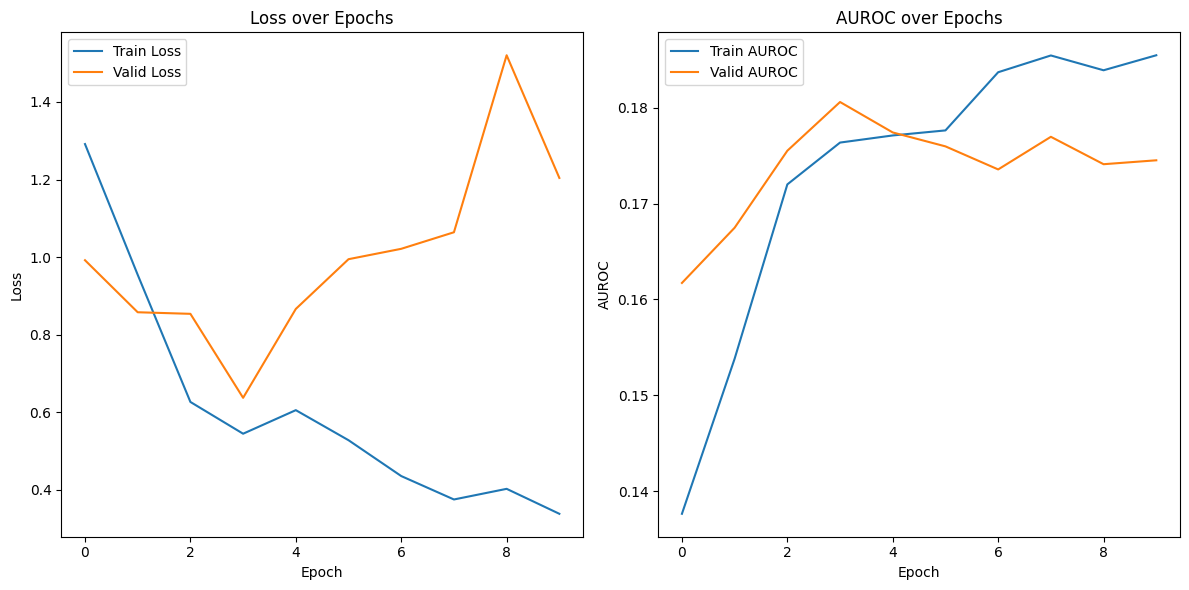

In [363]:
print('Best AUROC:' ,history['Valid AUROC'].max())
# After the training loop
plt.figure(figsize=(12, 6))

   # Loss graph
plt.subplot(1, 2, 1)
plt.plot(history['Train Loss'], label='Train Loss')
plt.plot(history['Valid Loss'], label='Valid Loss')
#plt.ylim([0.0, 0.77])
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

   # AUROC graph
plt.subplot(1, 2, 2)
plt.plot(history['Train AUROC'], label='Train AUROC')
plt.plot(history['Valid AUROC'], label='Valid AUROC')
plt.title('AUROC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.legend()

plt.tight_layout()
plt.show()

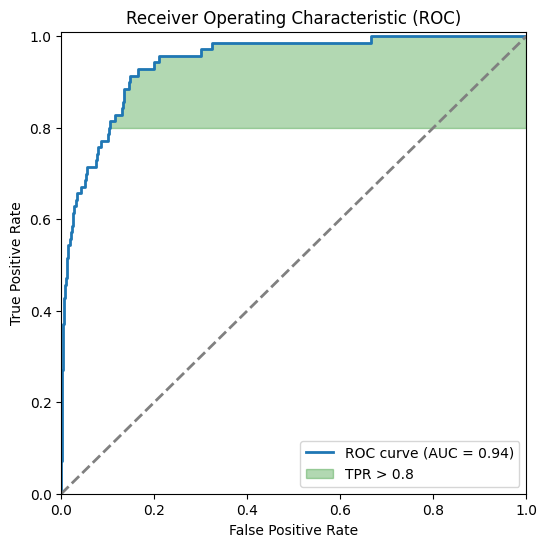

In [364]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

val_predictions = []
val_targets = []
model.eval()
with torch.no_grad():
    for data in valid_loader:
        images = data['image'].to(CONFIG['device'], dtype=torch.float)
        targets = data['target'].to(CONFIG['device'], dtype=torch.float)
        # index = data['index'].to(CONFIG['device'], dtype=torch.long) # Get indices for the batch
        # batch_tabular_data = tabular_data[index]
        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs).cpu().numpy()
        # inverted_outputs = 1.0 - outputs
        val_predictions.extend(probs)
        val_targets.extend(targets.cpu().numpy())

fpr, tpr, thresholds = roc_curve(val_targets, val_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.fill_between(fpr, tpr, 0.8, where=(tpr > 0.8), color='green', alpha=0.3, label='TPR > 0.8')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [365]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(val_targets, val_predictions)

desired_recall = 0.95

best_threshold = thresholds[np.argmin(np.abs(recall - desired_recall))]

print(f"Best Threshold (for recall of {desired_recall:.2f}): {best_threshold}")

val_predictions_labels = (np.array(val_predictions) > best_threshold).astype(int)

Best Threshold (for recall of 0.95): 0.48005566000938416


Accuracy: 0.7928571428571428
Precision: 0.06666666666666667
Recall: 0.9428571428571428


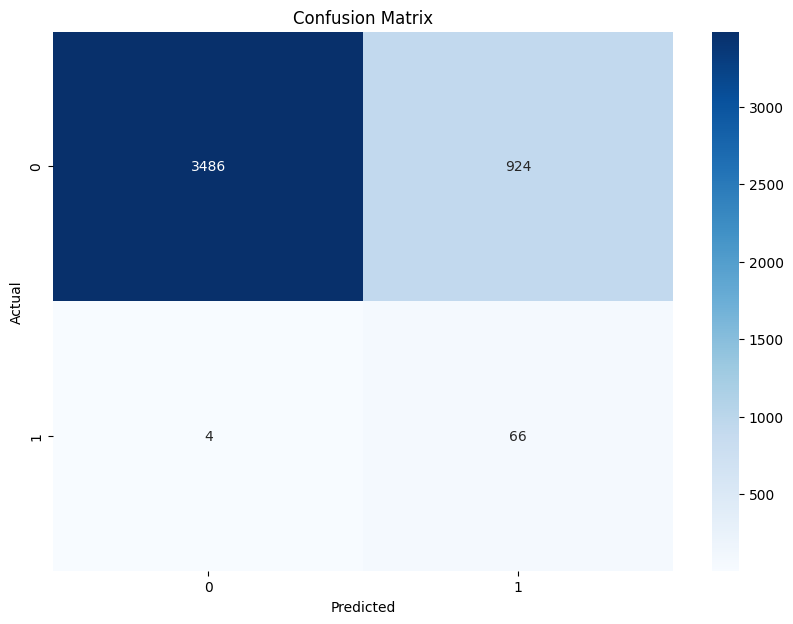

In [366]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

val_predictions_labels = (np.array(val_predictions) > best_threshold).astype(int) 

cm = confusion_matrix(val_targets, val_predictions_labels)

accuracy = accuracy_score(val_targets, val_predictions_labels)
precision = precision_score(val_targets, val_predictions_labels)
recall = recall_score(val_targets, val_predictions_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Comparing with specialists

In [367]:
def calculate_metrics(df, prediction_column):
    y_true = df['target']
    y_scores = df[prediction_column]

    solution_df = df[['target']].copy()
    submission_df = df[[prediction_column]].copy()
    pauc = score(solution_df, submission_df)

    if len(np.unique(y_true)) < 2:
        auroc = np.nan 
    else:
        auroc = roc_auc_score(y_true, y_scores)

    threshold = 0.5
    y_pred_binary = (y_scores >= threshold).astype(int)

    accuracy = accuracy_score(y_true, y_pred_binary)

    if np.sum(y_true) == 0 and np.sum(y_pred_binary) == 0:
        recall = np.nan
        precision = np.nan
    elif np.sum(y_pred_binary) == 0:
         recall = 0.0
         precision = np.nan
    elif np.sum(y_true) == 0:
        recall = np.nan
        precision = 0.0
    else:
        recall = recall_score(y_true, y_pred_binary)
        precision = precision_score(y_true, y_pred_binary)

    metrics = {
        'pAUC': pauc,
        'AUROC': auroc,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision
    }

    return metrics

In [368]:
images_shown = [
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0811515.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0541500.jpg', # B
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5366444.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_7316504.jpg', # M4
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_9941820.jpg', # Benign
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0367323.jpg', # Benign 6
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_3981469.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_2914336.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_7361410.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_8908294.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_1414922.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0454210.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_3143290.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0521800.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_3065830.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_9669746.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_8378513.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_3306890.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5738700.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0323417.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5691802.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_9811770.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_2085558.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_6960640.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_4239987.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_8128501.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_8109237.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_1942623.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0228301.jpg', 
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5497738.jpg',  #B 30
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_1699474.jpg',  #B 31
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5677120.jpg',  #M 32
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_4308153.jpg', #M
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_2318247.jpg', #M
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0968965.jpg', #M
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_4629159.jpg', #M
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_6424909.jpg', #M
]

In [369]:
augmented_shown = []

for image in images_shown:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    augmented = data_transforms_exp['valid'](image=img)['image']
    augmented_shown.append(augmented)

In [370]:
targets = []

for image_paths in images_shown:
    real_class = float(train_metadata[train_metadata['file_path'] == image_paths]['target'])
    targets.append(real_class)

In [371]:
probs = []

for image in augmented_shown:
    input_image = image.unsqueeze(0).to(CONFIG['device'])
    with torch.no_grad():
        output = model(input_image.to(CONFIG['device']))
        probability = torch.sigmoid(output).item()
        probs.append(probability)

In [372]:
np.array(probs).round(2)

array([0.53, 0.45, 0.72, 0.62, 0.62, 0.39, 0.35, 0.52, 0.22, 0.57, 0.51,
       0.45, 0.5 , 0.23, 0.44, 0.45, 0.4 , 0.56, 0.42, 0.43, 0.59, 0.37,
       0.64, 0.44, 0.41, 0.51, 0.48, 0.39, 0.41, 0.48, 0.58, 0.65, 0.62,
       0.68, 0.55, 0.62, 0.59])

In [373]:
data = """
Image,Lesion Type,Onco1,Onco2
1,M,60%,30%
2,B,0%,0%
3,M,0%,0%
4,M,30%,20%
5,B,0%,0%
6,B,0%,0%
7,B,0%,0%
8,B,0%,0%
9,B,0%,0%
10,B,0%,0%
11,B,0%,0%
12,B,0%,0%
13,B,0%,0%
14,B,0%,0%
15,B,0%,0%
16,B,0%,0%
17,B,0%,0%
18,B,0%,0%
19,B,0%,0%
20,B,0%,0%
21,B,0%,0%
22,B,0%,0%
23,B,0%,50%
24,B,0%,0%
25,B,0%,0%
26,B,0%,0%
27,B,0%,0%
28,B,0%,0%
29,B,0%,0%
30,B,0%,0%
31,B,50%,30%
32,M,80%,20%
33,M,0%,0%
34,M,0%,0%
35,M,0%,0%
36,M,0%,60%
37,M,0%,0%
"""

from io import StringIO
clinic = pd.read_csv(StringIO(data), index_col='Image')

for col in ['Onco1', 'Onco2']:
    clinic[col] = clinic[col].str.rstrip('%').astype('float') / 100.0

clinic['target'] = clinic['Lesion Type'].apply(lambda x: 1 if x == 'M' else 0)

print(clinic)

      Lesion Type  Onco1  Onco2  target
Image                                  
1               M    0.6    0.3       1
2               B    0.0    0.0       0
3               M    0.0    0.0       1
4               M    0.3    0.2       1
5               B    0.0    0.0       0
6               B    0.0    0.0       0
7               B    0.0    0.0       0
8               B    0.0    0.0       0
9               B    0.0    0.0       0
10              B    0.0    0.0       0
11              B    0.0    0.0       0
12              B    0.0    0.0       0
13              B    0.0    0.0       0
14              B    0.0    0.0       0
15              B    0.0    0.0       0
16              B    0.0    0.0       0
17              B    0.0    0.0       0
18              B    0.0    0.0       0
19              B    0.0    0.0       0
20              B    0.0    0.0       0
21              B    0.0    0.0       0
22              B    0.0    0.0       0
23              B    0.0    0.5       0


In [377]:
def calculate_metrics(df, prediction_column, min_tpr=0.80, ml=False):
    y_true = df['target']
    y_scores = df[prediction_column]

    solution_df = df[['target']].copy()
    submission_df = df[[prediction_column]].copy()
    pauc = score(solution_df, submission_df, min_tpr=min_tpr)

    if len(np.unique(y_true)) < 2:
        auroc = np.nan # Cannot calculate AUROC if only one class is present
    else:
        auroc = roc_auc_score(y_true, y_scores)

    if ml is True:
        threshold = 0.48
    else:
        threshold = 0.5
    y_pred_binary = (y_scores >= threshold).astype(int)

    accuracy = accuracy_score(y_true, y_pred_binary)

    if np.sum(y_true) == 0 and np.sum(y_pred_binary) == 0:
        recall = np.nan # Or 1.0 if desired, depending on definition
        precision = np.nan # Or 1.0 if desired
    elif np.sum(y_pred_binary) == 0:
         recall = 0.0 # Cannot have true positives if no predictions are positive
         precision = np.nan # Cannot calculate precision if no predictions are positive
    elif np.sum(y_true) == 0:
        recall = np.nan # Cannot calculate recall if no true positives
        precision = 0.0 # Cannot have false positives if no true positives
    else:
        recall = recall_score(y_true, y_pred_binary)
        precision = precision_score(y_true, y_pred_binary)

    metrics = {
        'pAUC': pauc,
        'AUROC': auroc,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision
    }

    return metrics

In [378]:
for_metrics = {
    'target': targets,
    'probs': probs
}
for_metrics = pd.DataFrame(for_metrics)

In [379]:
metrics_onco1 = calculate_metrics(clinic, 'Onco1')
print("Metrics using Onco1 as prediction:")
print(metrics_onco1)

# Calculate metrics using 'Onco2' as the prediction column
metrics_onco2 = calculate_metrics(clinic, 'Onco2')
print("\nMetrics using Onco2 as prediction:")
print(metrics_onco2)

metrics_ml = calculate_metrics(for_metrics, 'probs', ml=True)
print("\nMetrics using ML as prediction:")
print(metrics_ml)

Metrics using Onco1 as prediction:
{'pAUC': 0.028928571428571418, 'AUROC': 0.6507936507936507, 'Accuracy': 0.7837837837837838, 'Recall': 0.2222222222222222, 'Precision': 0.6666666666666666}

Metrics using Onco2 as prediction:
{'pAUC': 0.03342857142857142, 'AUROC': 0.6805555555555556, 'Accuracy': 0.7567567567567568, 'Recall': 0.1111111111111111, 'Precision': 0.5}

Metrics using ML as prediction:
{'pAUC': 0.1571428571428571, 'AUROC': 0.9285714285714286, 'Accuracy': 0.6756756756756757, 'Recall': 1.0, 'Precision': 0.42857142857142855}


In [380]:
# Prepare data for plotting
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUROC', 'pAUC'],
    'ML Model': [metrics_ml['Accuracy'], metrics_ml['Precision'], metrics_ml['Recall'], metrics_ml['AUROC'], metrics_ml['pAUC']],
    'Onco1': [metrics_onco1['Accuracy'], metrics_onco1['Precision'], metrics_onco1['Recall'], metrics_onco1['AUROC'], metrics_onco1['pAUC']],
    'Onco2': [metrics_onco2['Accuracy'], metrics_onco2['Precision'], metrics_onco2['Recall'], metrics_onco2['AUROC'], metrics_onco2['pAUC']]
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

,Metric,ML Model,Onco1,Onco2
0,Accuracy,0.675676,0.783784,0.756757
1,Precision,0.428571,0.666667,0.500000
2,Recall,1.000000,0.222222,0.111111
3,AUROC,0.928571,0.650794,0.680556
4,pAUC,0.157143,0.028929,0.033429


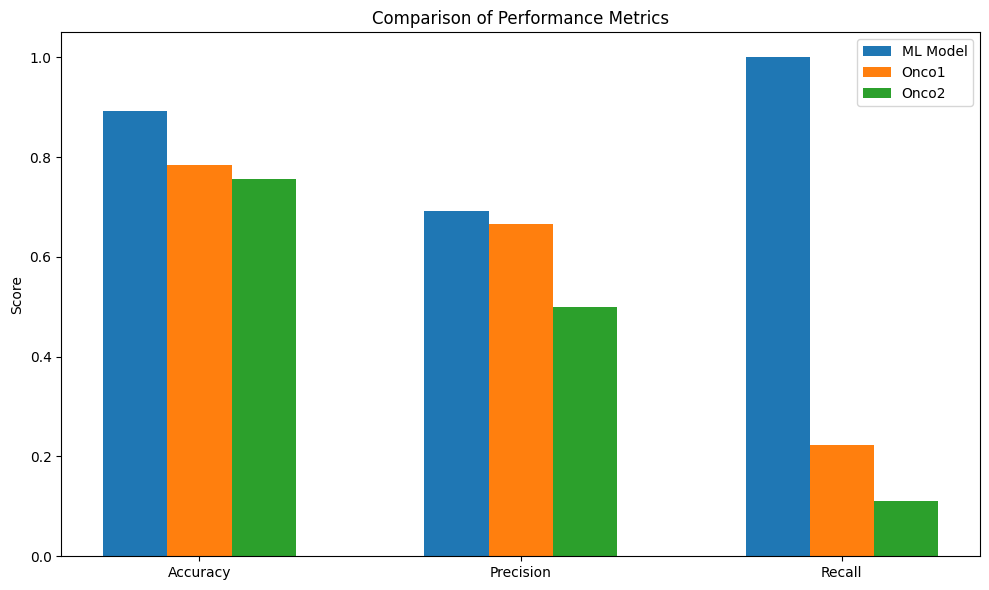

In [125]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall']
models = ['ML Model', 'Onco1', 'Onco2']

x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, metrics_df[metrics_df['Metric'].isin(metrics)]['ML Model'], width, label='ML Model')
rects2 = ax.bar(x, metrics_df[metrics_df['Metric'].isin(metrics)]['Onco1'], width, label='Onco1')
rects3 = ax.bar(x + width, metrics_df[metrics_df['Metric'].isin(metrics)]['Onco2'], width, label='Onco2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Comparison of Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

plt.show()

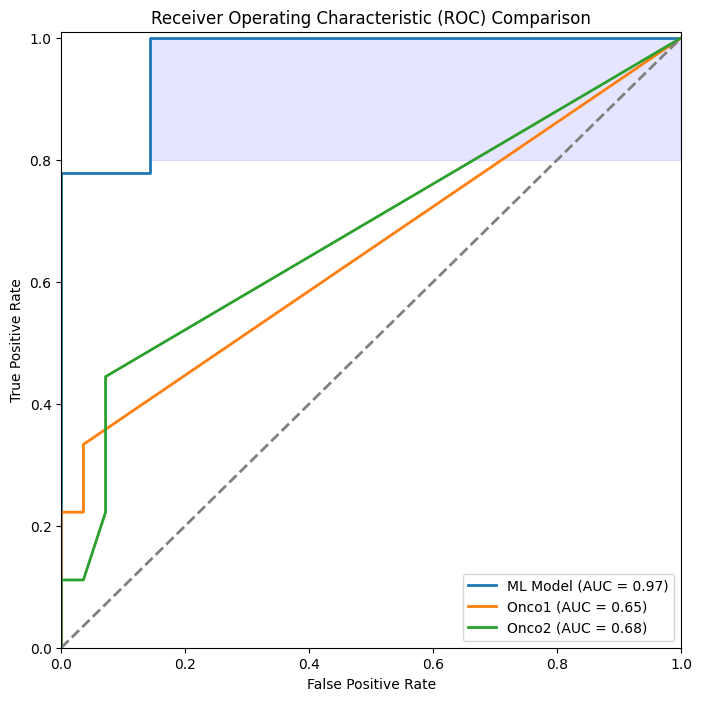

In [155]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

true_targets = clinic['target']

fpr_ml, tpr_ml, _ = roc_curve(true_targets, for_metrics['probs'])
roc_auc_ml = auc(fpr_ml, tpr_ml)

fpr_onco1, tpr_onco1, _ = roc_curve(true_targets, clinic['Onco1'])
roc_auc_onco1 = auc(fpr_onco1, tpr_onco1)

fpr_onco2, tpr_onco2, _ = roc_curve(true_targets, clinic['Onco2'])
roc_auc_onco2 = auc(fpr_onco2, tpr_onco2)

plt.figure(figsize=(7, 7))
plt.plot(fpr_ml, tpr_ml, lw=2, label=f'ML Model (AUC = {roc_auc_ml:.2f})')
plt.plot(fpr_onco1, tpr_onco1, lw=2, label=f'Onco1 (AUC = {roc_auc_onco1:.2f})')
plt.plot(fpr_onco2, tpr_onco2, lw=2, label=f'Onco2 (AUC = {roc_auc_onco2:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Highlight the region where TPR > 0.8 for all curves
plt.fill_between(fpr_ml, tpr_ml, 0.8, where=(tpr_ml > 0.8), color='blue', alpha=0.1)
plt.fill_between(fpr_onco1, tpr_onco1, 0.8, where=(tpr_onco1 > 0.8), color='orange', alpha=0.1)
plt.fill_between(fpr_onco2, tpr_onco2, 0.8, where=(tpr_onco2 > 0.8), color='green', alpha=0.1)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Comparison')
plt.legend(loc='lower right')
plt.show()

## XAI

In [127]:
image_paths = [
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0811515.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0541500.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5366444.jpg', # Malignant
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_7316504.jpg', # Malignant
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0322693.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0287703.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5400739.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_1792562.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5497738.jpg',
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_9941820.jpg', # Benign
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0367323.jpg',# Benign
    '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_5677120.jpg',  #M
     '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_4308153.jpg', #M
     '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_2318247.jpg', #M
     '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0968965.jpg', #M
     '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_4629159.jpg', #M
     '/kaggle/input/isic-2024-challenge/train-image/image/ISIC_6424909.jpg', #M
]

In [128]:
tabular_sample = train_metadata_applied.query(
    'file_path == "/kaggle/input/isic-2024-challenge/train-image/image/ISIC_7316504.jpg"'
).drop(['target', 'file_path', 'patient_id', 'kfold'], axis=1)

In [129]:
tabular_sample = torch.tensor(tabular_sample.values.astype(np.float32)).to(CONFIG['device'])

In [130]:
img = cv2.imread(image_paths[9])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

if img.shape[0] != CONFIG['img_size'] or img.shape[1] != CONFIG['img_size']:
    img = cv2.resize(img, (CONFIG['img_size'], CONFIG['img_size']))  # OpenCV uses (width, height)

img.shape

(224, 224, 3)

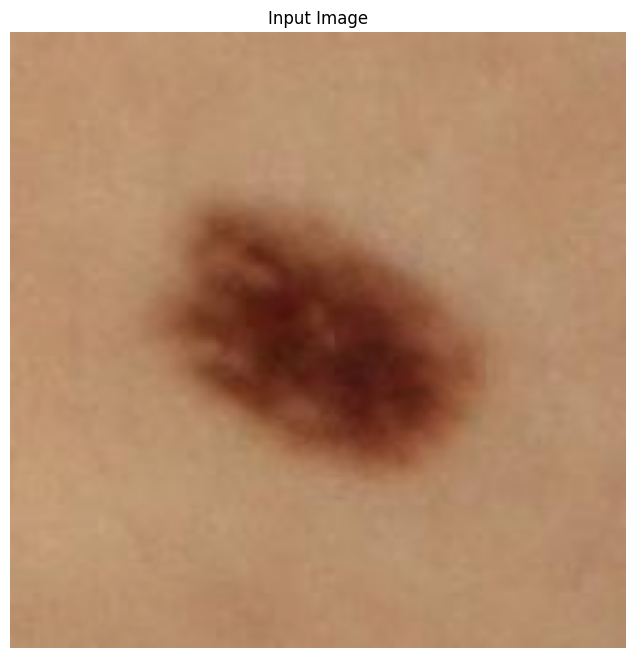

In [131]:
plt.figure(figsize=(8, 8))
plt.imshow(img)  # Display input image
plt.title("Input Image")
plt.axis('off')
plt.show()

In [132]:
augmented = data_transforms_exp['valid'](image=img)['image']

In [133]:
augmented.shape

torch.Size([3, 224, 224])

In [134]:
input_image = augmented.unsqueeze(0).to(CONFIG['device'])

with torch.no_grad():
    output = model(input_image)
    probability = torch.sigmoid(output).item()
    #real_prob = 1 - probability
    real_class = float(train_metadata[train_metadata['file_path'] == image_paths[9]]['target'])

print(probability)
print(real_class)

0.6210631728172302
0.0


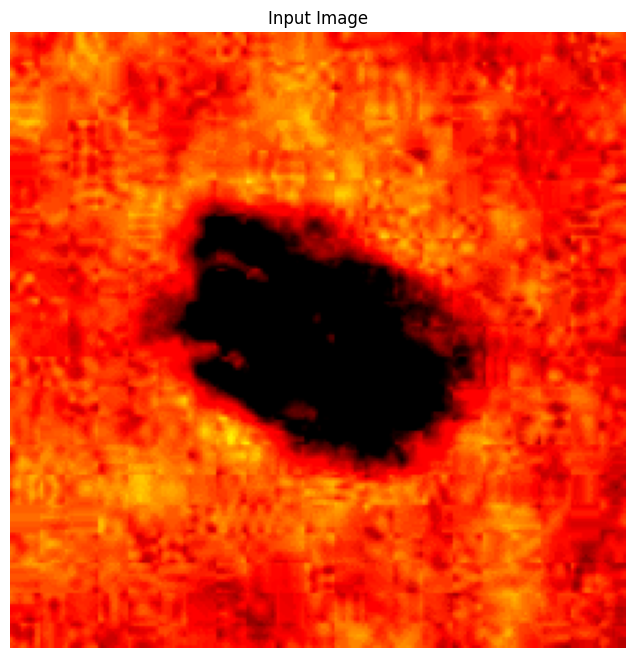

In [135]:
plt.figure(figsize=(8, 8))
plt.imshow(input_image.cpu().squeeze().permute(1, 2, 0))  # Display input image
plt.title("Input Image")
plt.axis('off')
plt.show()

In [136]:
target_layers = [model.conv_head]

In [137]:
target_layers

[Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)]

In [138]:
cam_target = [BinaryClassifierOutputTarget(int(real_class))]

In [139]:
rgb_img = img
if rgb_img.max() > 1.0:
    rgb_img = rgb_img / 255.0

rgb_img.shape

(224, 224, 3)

In [140]:
with GradCAM(model=model, target_layers=target_layers) as cam:
  grayscale_cam = cam(input_tensor=input_image, targets=cam_target)
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  model_outputs = cam.outputs

In [141]:
with ScoreCAM(model=model, target_layers=target_layers) as cam:
  grayscale_cam = cam(input_tensor=input_image, targets=cam_target)
  grayscale_cam = grayscale_cam[0, :]
  score_visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  model_outputs = cam.outputs

100%|██████████| 128/128 [00:11<00:00, 11.46it/s]


In [142]:
with XGradCAM(model=model, target_layers=target_layers) as cam:
  grayscale_cam = cam(input_tensor=input_image, targets=cam_target)
  grayscale_cam = grayscale_cam[0, :]
  xgrad_visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  model_outputs = cam.outputs

In [143]:
with AblationCAM(model=model, target_layers=target_layers) as cam:
  grayscale_cam = cam(input_tensor=input_image, targets=cam_target)
  grayscale_cam = grayscale_cam[0, :]
  ablation_visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  model_outputs = cam.outputs

100%|██████████| 64/64 [00:08<00:00,  7.60it/s]


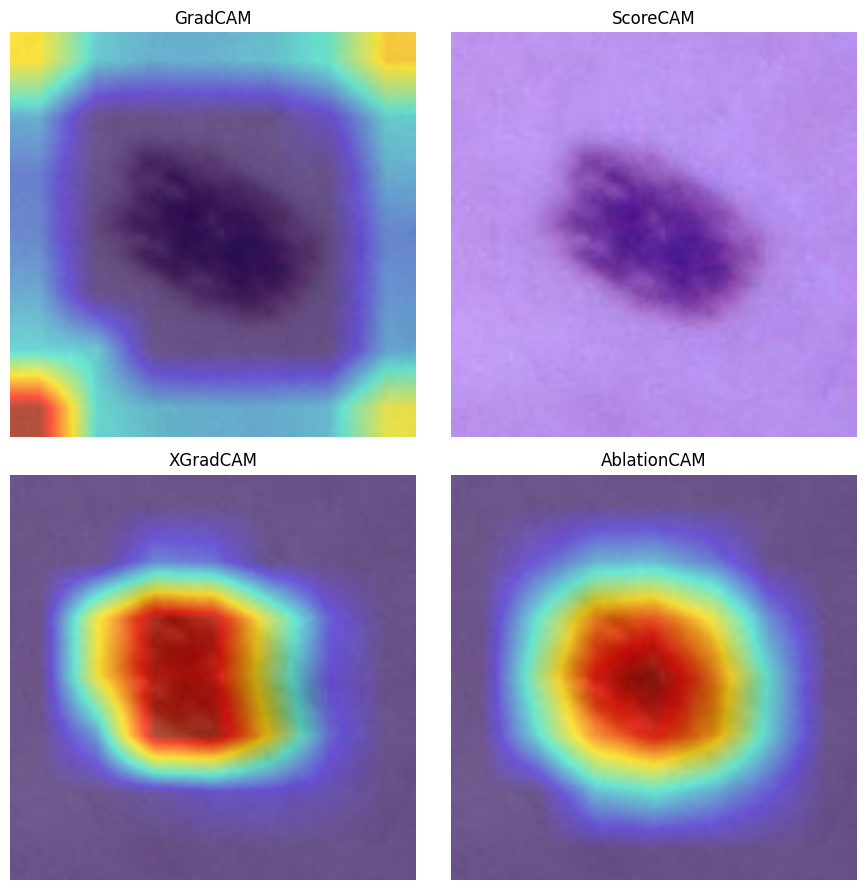

In [144]:
plt.figure(figsize=(9, 9))  # Adjust figure size for better spacing

# Top-left: GradCAM
plt.subplot(2, 2, 1)  # (rows, cols, index)
plt.imshow(visualization)
plt.title("GradCAM")
plt.axis('off')

# Top-right: ScoreCAM
plt.subplot(2, 2, 2)
plt.imshow(score_visualization)
plt.title("ScoreCAM")
plt.axis('off')

# Bottom-left: XGradCAM
plt.subplot(2, 2, 3)
plt.imshow(xgrad_visualization)
plt.title("XGradCAM")
plt.axis('off')

# Bottom-right: AblationCAM
plt.subplot(2, 2, 4)
plt.imshow(ablation_visualization)
plt.title("AblationCAM")
plt.axis('off')

plt.tight_layout()  # Prevent overlapping titles/labels
plt.show()

## Inference

In [145]:
import h5py
from PIL import Image
from io import BytesIO

In [146]:
TEST_CSV = f'{ROOT_DIR}/test-metadata.csv'
TEST_HDF = f'{ROOT_DIR}/test-image.hdf5'
SAMPLE = f'{ROOT_DIR}/sample_submission.csv'

In [147]:
df = pd.read_csv(TEST_CSV)
df['target'] = 0 # dummy
df.shape

(3, 45)

In [148]:
df_sub = pd.read_csv(SAMPLE)
df_sub

,isic_id,target
0,ISIC_0015657,0.3
1,ISIC_0015729,0.3
2,ISIC_0015740,0.3


In [149]:
class ISICDataset_inference(Dataset):
    def __init__(self, df, file_hdf, transforms=None):
        self.df = df
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.targets = df['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        img = np.array( Image.open(BytesIO(self.fp_hdf[isic_id][()])) )
        target = self.targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target,
        }

In [150]:
test_dataset = ISICDataset_inference(df, TEST_HDF, transforms=data_transforms["valid"])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'],
                          num_workers=2, shuffle=False, pin_memory=True)

In [151]:
preds = []
with torch.no_grad():
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, data in bar:
        images = data['image'].to(CONFIG["device"], dtype=torch.float)
        batch_size = images.size(0)
        outputs = model(images)
        preds.append( outputs.detach().cpu().numpy() )
preds = np.concatenate(preds).flatten()

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


In [152]:
df_sub["target"] = preds
df_sub.to_csv("submission.csv", index=False)

In [153]:
df_sub

,isic_id,target
0,ISIC_0015657,-0.704295
1,ISIC_0015729,-1.084005
2,ISIC_0015740,-0.499475
